# Trading Strategy 1: Classification



Strategies used: Decision Tree, Random Forest and SVM 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import pandas_ta as ta
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import scipy.optimize as sco
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [2]:
pd.options.plotting.backend = 'plotly'

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Data Preprocessing

In [4]:
stocks = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [5]:
data = pd.read_csv("data/tr_eikon_eod_data.csv", index_col=0, parse_dates=True)[stocks]
df = data.dropna()
df

AAPL.O  MSFT.O  INTC.O   AMZN.O    GS.N
Date                                                   
2010-01-04   30.572827  30.950   20.88   133.90  173.08
2010-01-05   30.625684  30.960   20.87   134.69  176.14
2010-01-06   30.138541  30.770   20.80   132.25  174.26
2010-01-07   30.082827  30.452   20.60   130.00  177.67
2010-01-08   30.282827  30.660   20.83   133.52  174.31
...                ...     ...     ...      ...     ...
2018-06-25  182.170000  98.390   50.71  1663.15  221.54
2018-06-26  184.430000  99.080   49.67  1691.09  221.58
2018-06-27  184.160000  97.540   48.76  1660.51  220.18
2018-06-28  185.500000  98.630   49.25  1701.45  223.42
2018-06-29  185.110000  98.610   49.71  1699.80  220.57

[2138 rows x 5 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
dtypes: float64(5)
memory usage: 100.2 KB


In [7]:
df.describe()

AAPL.O       MSFT.O       INTC.O       AMZN.O         GS.N
count  2138.000000  2138.000000  2138.000000  2138.000000  2138.000000
mean     93.455973    44.561115    29.364192   480.461251   170.216221
std      40.551559    19.527712     8.172160   372.307818    42.483935
min      27.435687    23.010000    17.665000   108.610000    87.700000
25%      60.294225    28.566875    22.510000   213.595000   146.607500
50%      90.550624    39.660000    27.330000   322.065000   164.430000
75%     117.235000    54.372500    34.710000   698.850000   192.132500
max     193.980000   102.490000    57.080000  1750.080000   273.380000

In [8]:
# plot stock price
fig = make_subplots(rows=5, cols=1)

for i in range(1,6):
    fig.add_trace(go.Scatter(x=df.index, y=df[stocks[i-1]], mode='lines'), row=i, col=1)

    fig.update_traces(showlegend=False, row=i, col=1)
    fig.update_xaxes(title_text=f'{stocks[i-1]} Stock Price', row=i, col=1)

fig.update_layout(title_text="Stock Price", height=1000, width=1000)
fig.show()

In [8]:
# compute RSI using pandas-ta library
# window length = 14
for i in range(1,6):
    stock_name = stocks[i-1]
    df[stock_name+'_rsi'] = df[[stock_name]].ta.rsi(close=stock_name)

In [9]:
# compute MACD using pandas-ta library
# short window = 12, long window = 26
# signal window = 9
# Calculation of features includes and uses:
    # MACD = EMA(close, fast) - EMA(close, slow)
    # Signal = EMA(MACD, signal)
    # Histogram = MACD - Signal
for i in range(1,6):
    stock_name = stocks[i-1]
    t = df[[stock_name]].ta.macd(close=stock_name).values.T
    df[stock_name+'_macd'] = t[0]
    df[stock_name+'_macd_hist'] = t[1]
    df[stock_name+'_macd_signal'] = t[2]

In [10]:
df.dropna(inplace=True)

In [11]:
df.head(10)

AAPL.O   MSFT.O   INTC.O  AMZN.O    GS.N  AAPL.O_rsi  \
Date                                                                  
2010-02-22  28.630829  28.7300  20.8700  118.01  156.71   47.612192   
2010-02-23  28.151258  28.3300  20.3880  117.24  156.70   43.102223   
2010-02-24  28.665114  28.6300  20.7000  119.72  158.33   48.708501   
2010-02-25  28.857114  28.6000  20.6300  118.20  156.44   50.664559   
2010-02-26  29.231399  28.6700  20.5300  118.40  156.35   54.321633   
2010-03-01  29.855684  29.0200  20.8700  124.54  156.54   59.689020   
2010-03-02  29.835684  28.4600  20.6975  125.53  158.75   59.448018   
2010-03-03  29.904256  28.4600  20.5200  125.89  157.72   60.043693   
2010-03-04  30.101398  28.6300  20.5300  128.53  163.61   61.781854   
2010-03-05  31.278540  28.5875  20.7900  128.91  167.18   70.135748   

            MSFT.O_rsi  INTC.O_rsi  AMZN.O_rsi   GS.N_rsi  ...  \
Date                                                       ...   
2010-02-22   46.780363   59.006934   41.535034  47.402695  ...   
2010-02-23   41.874436   50.818283   39.909518  47.383014  ...   
2010-02-24   46.413428   55.156407   47.091552  50.957331  ...   
2010-02-25   46.026363   54.005437   43.648176  46.972840  ...   
2010-02-26   47.134201   52.325594   44.226064  46.785237  ...   
2010-03-01   52.395547   57.200170   58.348013  47.264083  ...   
2010-03-02   44.725743   54.173710   60.102153  52.606147  ...   
2010-03-03   44.725743   51.173336   60.749484  50.060895  ...   
2010-03-04   47.434802   51.336857   65.207560  61.524910  ...   
2010-03-05   46.817036   55.508888   65.809526  66.538803  ...   

            MSFT.O_macd_signal  INTC.O_macd  INTC.O_macd_hist  \
Date                                                            
2010-02-22           -0.830562    -0.032883          0.269524   
2010-02-23           -0.768744    -0.031501          0.216724   
2010-02-24           -0.709744    -0.005171          0.194444   
2010-02-25           -0.654465     0.009933          0.167638   
2010-02-26           -0.601807     0.013677          0.137105   
2010-03-01           -0.546596     0.043576          0.133604   
2010-03-02           -0.500368     0.052744          0.114218   
2010-03-03           -0.461054     0.045167          0.085312   
2010-03-04           -0.424371     0.039513          0.063727   
2010-03-05           -0.390971     0.055374          0.063670   

            INTC.O_macd_signal  AMZN.O_macd  AMZN.O_macd_hist  \
Date                                                            
2010-02-22           -0.302407    -3.196120          0.733614   
2010-02-23           -0.248226    -3.059085          0.696519   
2010-02-24           -0.199615    -2.719025          0.829264   
2010-02-25           -0.157705    -2.542863          0.804340   
2010-02-26           -0.123429    -2.359912          0.789833   
2010-03-01           -0.090028    -1.699881          1.159892   
2010-03-02           -0.061473    -1.084415          1.420285   
2010-03-03           -0.040145    -0.561137          1.554851   
2010-03-04           -0.024214     0.065831          1.745455   
2010-03-05           -0.008296     0.586609          1.812987   

            AMZN.O_macd_signal  GS.N_macd  GS.N_macd_hist  GS.N_macd_signal  
Date                                                                         
2010-02-22           -3.929734  -3.279761        1.716440         -4.996201  
2010-02-23           -3.755604  -2.954048        1.633722         -4.587770  
2010-02-24           -3.548288  -2.535168        1.642082         -4.177250  
2010-02-25           -3.347203  -2.328863        1.478709         -3.807572  
2010-02-26           -3.149745  -2.147868        1.327763         -3.475632  
2010-03-01           -2.859772  -1.966429        1.207362         -3.173791  
2010-03-02           -2.504701  -1.625571        1.238576         -2.864147  
2010-03-03           -2.115988  -1.422156        1.153593         -2.575749  
2010-03-04           -1.679

In [13]:
# plot RSI
fig = make_subplots(rows=5, cols=1)
for i in range(1,6):
    stock_name = stocks[i-1]
    
    fig.add_trace(go.Scatter(x=df.index, y=df[stock_name+'_rsi'], mode='lines'), row=i, col=1)
    
    mean_rsi = df[stock_name+'_rsi'].mean()
    fig.add_hline(mean_rsi, line_dash = 'dash', line_width = 0.5, row=i, col=1)
    
    fig.add_hline(30, line_color="grey", line_width=0.8, row=i, col=1)
    fig.add_hline(70, line_color="grey", line_width=0.8, row=i, col=1)

    fig.update_traces(showlegend=False, row=i, col=1)
    fig.update_xaxes(title_text=f'{stock_name} Stock RSI', row=i, col=1)

fig.update_layout(title_text="RSI for Different Stocks", height=1000, width=1000)
fig.show()

In [14]:
# plot MACD. zoom in to view MACD histogram
fig = make_subplots(rows=5, cols=1)
for i in range(1,6):
    stock_name = stocks[i-1]
    
    fig.add_trace(go.Scatter(x=df.index, y=df[stock_name+'_macd'], mode='lines'), row=i, col=1)
    fig.add_trace(go.Bar(x=df.index, y=df[stock_name+'_macd_hist'], marker=dict(color='blue')), row=i, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[stock_name+'_macd_signal'], mode='lines'), row=i, col=1)

    fig.update_traces(showlegend=False, row=i, col=1)
    fig.update_xaxes(title_text=f'{stock_name} Stock MACD', row=i, col=1)

fig.update_layout(title_text="MACD for Different Stocks", height=1000, width=1000)
fig.show()

In [12]:
# compute log returns
for i in range(1, 6):
    stock_name = stocks[i-1]
    df[stock_name+'_returns'] = np.log(df[stock_name]/ df[stock_name].shift(1))

In [13]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    # record the direction (sign of log returns)
    df[stock_name+'_direction'] = np.sign(df[stock_name+'_returns']).dropna().astype(int)

In [14]:
df.dropna(inplace=True)

## Benchmarking Different Machine Learning Models

In [15]:
# perform train test split
train, test = train_test_split(df,
                               test_size = 0.2,
                               shuffle = True,
                               random_state = 0)
    
train = train.copy().sort_index()
test = test.copy().sort_index()

In [47]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    
    # use features of choice
    features = [stock_name+'_macd', stock_name+'_rsi']
    
    X_train = train[features]
    X_test = test[features]
    
    # Decision Tree Classifier
    dt = DecisionTreeClassifier(max_depth = 3)
    
    test[stock_name+'_Prediction_DT'] = dt.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Returns_DT'] = test[stock_name+'_Prediction_DT'] * test[stock_name+'_returns']
    
    # Support Vector Classifier
    svc = SVC()
    
    test[stock_name+'_Prediction_SVC'] = svc.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Returns_SVC'] = test[stock_name+'_Prediction_SVC'] * test[stock_name+'_returns']
    
    # Neural Networks
    nn = MLPClassifier(hidden_layer_sizes = [400]*4)
    
    test[stock_name+'_Prediction_NN'] = nn.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Returns_NN'] = test[stock_name+'_Prediction_NN'] * test[stock_name+'_returns']
    
    print(test[[stock_name+'_returns', stock_name+'_Returns_DT', stock_name+'_Returns_SVC', stock_name+'_Returns_NN']].sum().apply(np.exp))
    

AAPL.O_returns         1.679166
AAPL.O_Returns_DT     14.287909
AAPL.O_Returns_SVC    12.470614
AAPL.O_Returns_NN      3.846337
dtype: float64
MSFT.O_returns        0.989126
MSFT.O_Returns_DT     6.836811
MSFT.O_Returns_SVC    5.223608
MSFT.O_Returns_NN     9.068851
dtype: float64
INTC.O_returns         1.240876
INTC.O_Returns_DT     11.012156
INTC.O_Returns_SVC     8.199407
INTC.O_Returns_NN     10.926916
dtype: float64
AMZN.O_returns         1.374306
AMZN.O_Returns_DT     11.885278
AMZN.O_Returns_SVC    12.216125
AMZN.O_Returns_NN     11.425688
dtype: float64
GS.N_returns         0.627202
GS.N_Returns_DT     14.447341
GS.N_Returns_SVC    24.006852
GS.N_Returns_NN     13.788089
dtype: float64


## Determining Portfolio Weights (with highest sharpe ratio)

In [16]:
log_rets = df[['AAPL.O_returns', 'MSFT.O_returns', 'INTC.O_returns', 'AMZN.O_returns', 'GS.N_returns']]

In [17]:
mu = log_rets.mean() * 252
Q = log_rets.cov() * 252

num_assets = 5
port_rets = []
port_var = []
for i in range(5000):
    w = npr.rand(num_assets)
    w /= np.sum(w)
    port_rets.append(mu.T @ w)
    port_var.append(w.T @ (Q @ w))

In [18]:
def max_returns(w):
    return -(mu.T @ w)

def min_var(w):
    return w.T @ (Q @ w)

def max_Sharpe_ratio(w):
    return -(mu.T @ w)/np.sqrt(w.T @ (Q @ w))

In [19]:
w0 = [1./num_assets] * num_assets
cons = ({'type': 'eq', 
         'fun': lambda w: np.sum(w) - 1})
bnds = tuple((0, 1) for x in range(num_assets))

In [20]:
result = sco.minimize(max_Sharpe_ratio, w0, 
                      constraints = cons, 
                      bounds = bnds)
result['x']

array([4.43855598e-01, 6.04287243e-02, 0.00000000e+00, 4.95715677e-01,
       1.66967135e-17])

In [21]:
ret_max_Sharpe = mu.T @ result['x']
vol_max_Sharpe = np.sqrt(np.sum(result['x'] *  np.dot(Q, result['x'])))

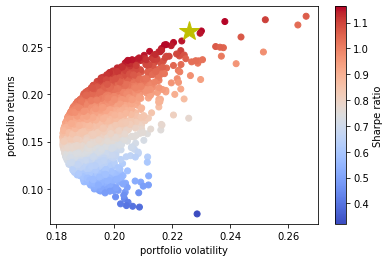

In [22]:
port_vol = np.sqrt(port_var)
plt.scatter(port_vol, port_rets, c = port_rets / port_vol, 
           cmap = 'coolwarm')
plt.plot(vol_max_Sharpe, ret_max_Sharpe, 'y*', markersize = 20)
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio returns')
plt.colorbar(label = 'Sharpe ratio');

In [23]:
# store the optimal Sharpe Ratio portfolio in a dictionary
optimal_weights = {}
for i in range(1, 6):
    stock_name = stocks[i-1]
    optimal_weights[stock_name + '_weight'] = result['x'][i-1]

In [24]:
optimal_weights

{'AAPL.O_weight': 0.44385559825884624,
 'MSFT.O_weight': 0.060428724261282665,
 'INTC.O_weight': 0.0,
 'AMZN.O_weight': 0.4957156774798713,
 'GS.N_weight': 1.6696713456276768e-17}

### Apply Portfolio Weights and Benchmark Machine Learning Models

In [34]:
df.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'AAPL.O_rsi',
       'MSFT.O_rsi', 'INTC.O_rsi', 'AMZN.O_rsi', 'GS.N_rsi', 'AAPL.O_macd',
       'AAPL.O_macd_hist', 'AAPL.O_macd_signal', 'MSFT.O_macd',
       'MSFT.O_macd_hist', 'MSFT.O_macd_signal', 'INTC.O_macd',
       'INTC.O_macd_hist', 'INTC.O_macd_signal', 'AMZN.O_macd',
       'AMZN.O_macd_hist', 'AMZN.O_macd_signal', 'GS.N_macd', 'GS.N_macd_hist',
       'GS.N_macd_signal', 'AAPL.O_returns', 'MSFT.O_returns',
       'INTC.O_returns', 'AMZN.O_returns', 'GS.N_returns', 'AAPL.O_direction',
       'MSFT.O_direction', 'INTC.O_direction', 'AMZN.O_direction',
       'GS.N_direction'],
      dtype='object')

In [30]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    
    # use features of choice
    features = [stock_name+'_macd', stock_name+'_rsi']
    
    X_train = train[features]
    X_test = test[features]

    # Decision Tree Classifier
    dt = DecisionTreeClassifier(max_depth = 3)

    test[stock_name+'_Prediction_DT'] = dt.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Prediction_DT'] *= optimal_weights[stock_name+'_weight']
    test[stock_name+'_Returns_DT'] = test[stock_name+'_Prediction_DT'] * test[stock_name+'_returns']
    
    # Support Vector Classifier
    svc = SVC()
    
    test[stock_name+'_Prediction_SVM'] = svc.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Prediction_SVM'] *= optimal_weights[stock_name+'_weight']
    test[stock_name+'_Returns_SVM'] = test[stock_name+'_Prediction_SVM'] * test[stock_name+'_returns']

    # Neural Networks
    nn = MLPClassifier(hidden_layer_sizes = [400]*4)
    
    test[stock_name+'_Prediction_NN'] = nn.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Prediction_NN'] *= optimal_weights[stock_name+'_weight']
    test[stock_name+'_Returns_NN'] = test[stock_name+'_Prediction_NN'] * test[stock_name+'_returns']
    
    test[stock_name+'_returns'] *= optimal_weights[stock_name+'_weight']

In [31]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    print(test[[stock_name+'_returns', stock_name+'_Returns_DT', stock_name+'_Returns_SVM', stock_name+'_Returns_NN']].sum().apply(np.exp))

AAPL.O_returns        1.258662
AAPL.O_Returns_DT     3.255662
AAPL.O_Returns_SVM    3.064897
AAPL.O_Returns_NN     2.623086
dtype: float64
MSFT.O_returns        0.999340
MSFT.O_Returns_DT     1.123179
MSFT.O_Returns_SVM    1.105060
MSFT.O_Returns_NN     1.132285
dtype: float64
INTC.O_returns        1.0
INTC.O_Returns_DT     1.0
INTC.O_Returns_SVM    1.0
INTC.O_Returns_NN     1.0
dtype: float64
AMZN.O_returns        1.170712
AMZN.O_Returns_DT     3.411136
AMZN.O_Returns_SVM    3.457880
AMZN.O_Returns_NN     3.598802
dtype: float64
GS.N_returns        1.0
GS.N_Returns_DT     1.0
GS.N_Returns_SVM    1.0
GS.N_Returns_NN     1.0
dtype: float64


In [32]:
test['total_weighted_returns_DT'] = test['AAPL.O_Returns_DT'] + test['MSFT.O_Returns_DT'] + test['INTC.O_Returns_DT'] + test['AMZN.O_Returns_DT'] + test['GS.N_Returns_DT']
test['total_weighted_returns_SVM'] = test['AAPL.O_Returns_SVM'] + test['MSFT.O_Returns_SVM'] + test['INTC.O_Returns_SVM'] + test['AMZN.O_Returns_SVM'] + test['GS.N_Returns_SVM']
test['total_weighted_returns_NN'] = test['AAPL.O_Returns_NN'] + test['MSFT.O_Returns_NN'] + test['INTC.O_Returns_NN'] + test['AMZN.O_Returns_NN'] + test['GS.N_Returns_NN']
test['total_weighted_returns'] = test['AAPL.O_returns'] + test['MSFT.O_returns'] + test['INTC.O_returns'] + test['AMZN.O_returns'] + test['GS.N_returns']
print(test[['total_weighted_returns', 'total_weighted_returns_DT', 'total_weighted_returns_SVM', 'total_weighted_returns_NN']].sum().apply(np.exp))

total_weighted_returns         1.472557
total_weighted_returns_DT     12.473474
total_weighted_returns_SVM    11.711485
total_weighted_returns_NN     10.688736
dtype: float64


In [33]:
test[['total_weighted_returns', 'total_weighted_returns_DT', 'total_weighted_returns_SVM', 'total_weighted_returns_NN']].cumsum().apply(np.exp).plot()

## Hyperparameter Tuning of Decision Tree

In [19]:
tuning_df = []

for i in range(1, 6):
    stock_name = stocks[i-1]
    
    # obtain features and label
    features = [stock_name+'_macd', stock_name+'_rsi', stock_name+'_direction']
    
    for feature in features:
        tuning_df.append(feature)

In [24]:
df_tune = train[tuning_df] # use the training dataset to perform grid search and find best parameters

In [26]:
stock_dfs_from_df_tune = []

# loop through each stock symbol, filter columns for that stock, and reshape
for symbol in stocks:
    stock_df = df_tune.filter(regex=f'^{symbol}').copy()
    stock_df.columns = stock_df.columns.str.replace(f'{symbol}_', '')  # clean column names
    stock_df['Stock'] = symbol  # add stock symbol as a column
    stock_df['Date'] = stock_df.index  # add the index ('Date') as a column
    stock_df.set_index('Date', inplace=True)  # set 'Date' as the index
    stock_dfs_from_df_tune.append(stock_df)

# concatenate all stock dataframes from df_tune, keeping 'Date' as the index
long_df_from_df_tune = pd.concat(stock_dfs_from_df_tune).sort_index()

long_df_from_df_tune.head(n=10)

macd        rsi  direction   Stock
Date                                              
2010-02-23 -0.364335  43.102223       -1.0  AAPL.O
2010-02-23 -0.521472  41.874436       -1.0  MSFT.O
2010-02-23 -2.954048  47.383014       -1.0    GS.N
2010-02-23 -0.031501  50.818283       -1.0  INTC.O
2010-02-23 -3.059085  39.909518       -1.0  AMZN.O
2010-02-25 -0.433347  46.026363       -1.0  MSFT.O
2010-02-25  0.009933  54.005437       -1.0  INTC.O
2010-02-25 -2.542863  43.648176       -1.0  AMZN.O
2010-02-25 -2.328863  46.972840       -1.0    GS.N
2010-02-25 -0.279990  50.664559        1.0  AAPL.O

In [29]:
X_tune = long_df_from_df_tune[['macd', 'rsi']]
y_tune = long_df_from_df_tune[['direction']]
X_tune, y_tune

(                 macd        rsi
 Date                            
 2010-02-23  -0.364335  43.102223
 2010-02-23  -0.521472  41.874436
 2010-02-23  -2.954048  47.383014
 2010-02-23  -0.031501  50.818283
 2010-02-23  -3.059085  39.909518
 ...               ...        ...
 2018-06-29   0.071924  46.449194
 2018-06-29  -1.327252  33.824162
 2018-06-29  19.777389  55.393287
 2018-06-29  -0.473600  46.040430
 2018-06-29  -3.936894  31.639055
 
 [8415 rows x 2 columns],
             direction
 Date                 
 2010-02-23       -1.0
 2010-02-23       -1.0
 2010-02-23       -1.0
 2010-02-23       -1.0
 2010-02-23       -1.0
 ...               ...
 2018-06-29       -1.0
 2018-06-29        1.0
 2018-06-29       -1.0
 2018-06-29       -1.0
 2018-06-29       -1.0
 
 [8415 rows x 1 columns])

In [30]:
param_grid = {
    'max_depth': [None] + list(np.arange(1,11)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()

# initiate grid search model
grid_search = GridSearchCV(dt, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 1)

grid_search.fit(X_tune, y_tune)

# print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best score found:  0.6552584670231729


In [41]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    
    # use features of choice
    features = [stock_name+'_macd', stock_name+'_rsi']
    
    X_train = train[features]
    X_test = test[features]

    # Decision Tree Classifier
    dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6, min_samples_split = 2, criterion = 'entropy')

    test[stock_name+'_Prediction_DT'] = dt.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Prediction_DT'] *= optimal_weights[stock_name+'_weight']
    test[stock_name+'_Returns_DT'] = test[stock_name+'_Prediction_DT'] * test[stock_name+'_returns']
    
    test[stock_name+'_returns'] *= optimal_weights[stock_name+'_weight']

In [42]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    print(test[[stock_name+'_returns', stock_name+'_Returns_DT']].sum().apply(np.exp))

AAPL.O_returns       1.258662
AAPL.O_Returns_DT    3.207905
dtype: float64
MSFT.O_returns       0.999340
MSFT.O_Returns_DT    1.108066
dtype: float64
INTC.O_returns       1.0
INTC.O_Returns_DT    1.0
dtype: float64
AMZN.O_returns       1.170712
AMZN.O_Returns_DT    3.117444
dtype: float64
GS.N_returns       1.0
GS.N_Returns_DT    1.0
dtype: float64


In [44]:
test['total_weighted_returns_DT'] = test['AAPL.O_Returns_DT'] + test['MSFT.O_Returns_DT'] + test['INTC.O_Returns_DT'] + test['AMZN.O_Returns_DT'] + test['GS.N_Returns_DT']
test['total_weighted_returns'] = test['AAPL.O_returns'] + test['MSFT.O_returns'] + test['INTC.O_returns'] + test['AMZN.O_returns'] + test['GS.N_returns']
print(test[['total_weighted_returns', 'total_weighted_returns_DT']].sum().apply(np.exp))

total_weighted_returns        1.472557
total_weighted_returns_DT    11.081172
dtype: float64


When hyperparameter tuning is done to the decision tree, total weighted returns fell.

This is probably due to the fact that the optimal parameters for the decision tree was obtained with training data containing all 5 stocks. In reality, different stocks might have different optimal parameters and it is difficult to find a one size fit all combination of parameters

In [25]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    
    # use features of choice
    features = [stock_name+'_macd', stock_name+'_rsi']
    
    X_train = train[features]
    X_test = test[features]

    # Decision Tree Classifier
    dt = DecisionTreeClassifier()
    
    param_grid = {
    'max_depth': [None] + list(np.arange(1,11)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'criterion': ['gini', 'entropy']
    }
    
    # initiate grid search model
    grid_search = GridSearchCV(dt, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 1)
    
    grid_search.fit(X_train, train[stock_name+'_direction'])
    
    # print the best parameters and the best score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    
    modified_dt = DecisionTreeClassifier(**grid_search.best_params_)

    test[stock_name+'_Prediction_DT'] = modified_dt.fit(X_train, train[stock_name+'_direction']).predict(X_test)
    test[stock_name+'_Prediction_DT'] *= optimal_weights[stock_name+'_weight']
    test[stock_name+'_Returns_DT'] = test[stock_name+'_Prediction_DT'] * test[stock_name+'_returns']
    
    test[stock_name+'_returns'] *= optimal_weights[stock_name+'_weight']

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best score found:  0.6636781121944326
Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score found:  0.6404991521831285
Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best score found:  0.6464621308464038
Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best score found:  0.6571446234280062
Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_

In [26]:
for i in range(1, 6):
    stock_name = stocks[i-1]
    print(test[[stock_name+'_returns', stock_name+'_Returns_DT']].sum().apply(np.exp))

AAPL.O_returns       1.258662
AAPL.O_Returns_DT    3.207905
dtype: float64
MSFT.O_returns       0.999340
MSFT.O_Returns_DT    1.123179
dtype: float64
INTC.O_returns       1.0
INTC.O_Returns_DT    1.0
dtype: float64
AMZN.O_returns       1.170712
AMZN.O_Returns_DT    3.117444
dtype: float64
GS.N_returns       1.0
GS.N_Returns_DT    1.0
dtype: float64


In [27]:
test['total_weighted_returns_DT'] = test['AAPL.O_Returns_DT'] + test['MSFT.O_Returns_DT'] + test['INTC.O_Returns_DT'] + test['AMZN.O_Returns_DT'] + test['GS.N_Returns_DT']
test['total_weighted_returns'] = test['AAPL.O_returns'] + test['MSFT.O_returns'] + test['INTC.O_returns'] + test['AMZN.O_returns'] + test['GS.N_returns']
print(test[['total_weighted_returns', 'total_weighted_returns_DT']].sum().apply(np.exp))

total_weighted_returns        1.472557
total_weighted_returns_DT    11.232316
dtype: float64
